In [ ]:
# Code block used for zipping files; Dont run this code again!

# import os
# from sklearn.model_selection import train_test_split
# import numpy as np

# from google.colab import drive
# drive.mount('/content/drive')
# cwd = os.getcwd()
# path = os.getcwd() + '/drive/MyDrive/ML Project/'
# os.chdir(path)
# !unzip ChestXRay2017.zip
# os.chdir(cwd)

file_name (train, test) => train,val,test => extract_feature(load image -> hog) ,
hog => svm (train,val), test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=14,8
RANDOM_SEED = 100
import cv2
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

import os
path = 'drive/MyDrive/ML_Project/chest_xray/'
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['test', 'train']

In [ ]:
def load_files(ds_path):
    unique_labels = os.listdir(ds_path)
    print(len(unique_labels))
    Images = []
    labels = []
    for i in range(len(unique_labels)):
        try:
          instances = os.listdir(ds_path + unique_labels[i])
          print(f"No. of {unique_labels[i]} instances = {len(instances)}")
          for img in instances:
              Images.append(ds_path + unique_labels[i]+"/"+img)
          labels.extend([unique_labels[i]]*len(instances))
        except Exception:
          print(f"Cant print for {unique_labels[i]}")
    return Images,labels

In [ ]:
#Not creating a separate X_val as we might end up overfitting that while hyper parameter tuning, instead we'll try K-fold cross validation in this version
#Reference https://stats.stackexchange.com/questions/378771/cross-validation-and-train-test-split
#The previous version can be restored from 18 April'21 2:21 PM
X_train, y_train = load_files(path +'train/')
X_test, y_test = load_files(path +'test/')

import random
random.seed(RANDOM_SEED)
temp_train = list(zip(X_train, y_train))
random.shuffle(temp_train)
X_train, y_train = zip(*temp_train)

temp_test = list(zip(X_test, y_test))
random.shuffle(temp_test)
X_test, y_test = zip(*temp_test)

2
No. of NORMAL instances = 1349
No. of PNEUMONIA instances = 3884
2
No. of PNEUMONIA instances = 390
No. of NORMAL instances = 234


In [ ]:
assert len(X_train)==len(y_train)
assert len(X_test)==len(y_test)

print(f"Size of training set = {len(X_train)}")
print(f"Size of testing set = {len(X_test)}")

Size of training set = 5233
Size of testing set = 624


In [ ]:
from skimage.feature import hog
def hog_img(img, size, display=False):
    resized_img = cv2.resize(img, size)

    #Resource for the different attributes: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
    features, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)

    if display:
        plt.imshow(hog_image,cmap='gray')

    return features


Text(0.5, 1.0, 'Hog Image')

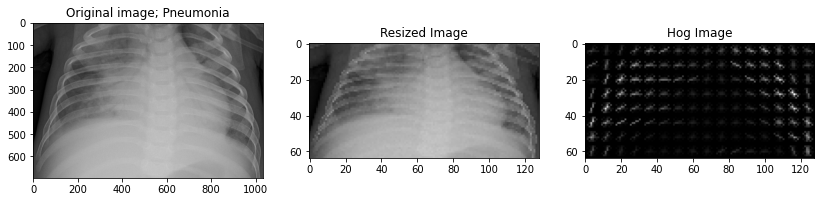

In [ ]:
#Taking a look at the images
img = cv2.imread(X_train[4000])
plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.title(f"Original image; Pneumonia" )

plt.subplot(1,3,2)
plt.imshow(cv2.resize(img, (128,64)),cmap='gray')
plt.title("Resized Image")

plt.subplot(1,3,3)
features=hog_img(img, (128,64), True)
plt.title("Hog Image")

Text(0.5, 1.0, 'Hog Image')

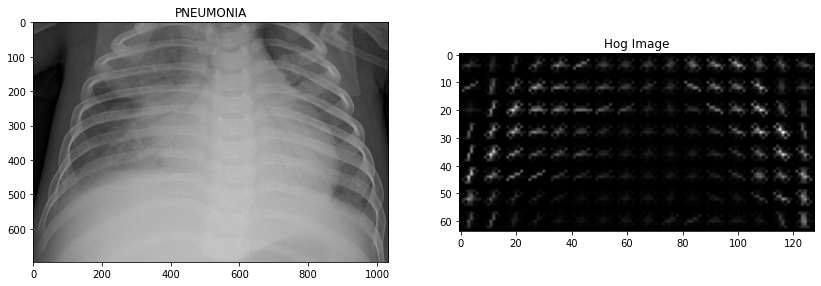

In [ ]:
#Taking a look at the images
img = cv2.imread(X_train[4000])
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.title(str(y_train[4000]))

plt.subplot(1,2,2)
features=hog_img(img, (128,64), True)
plt.title("Hog Image")

In [ ]:
def hog_img_datastore(data):
    ans = []
    for img_path in tqdm(data):
        try:
            img = cv2.imread(img_path)
            features=hog_img(img, (128,64))
            ans.append(features.tolist())
        except:
            ans.append(ans[-1])
            print("Error Occured! Adding NaN")
    return np.array(ans)

In [ ]:
print("Task started for X_train")
X_train_hog = hog_img_datastore(X_train)
print("Task finished for X_train")

print("Task started for X_test")
X_test_hog = hog_img_datastore(X_test)
print("Task finished for X_test")

  0%|          | 0/5233 [00:00<?, ?it/s]

Task started for X_train


 22%|██▏       | 1177/5233 [14:57<49:15,  1.37it/s]

Error Occured! Adding NaN


 89%|████████▉ | 4646/5233 [58:55<06:15,  1.56it/s]

Error Occured! Adding NaN


  0%|          | 0/624 [00:00<?, ?it/s]

Task finished for X_train
Task started for X_test


100%|██████████| 624/624 [07:01<00:00,  1.48it/s]

Task finished for X_test


In [ ]:
def label_encoder(data):
    ans = []
    for val in data:
        if val == 'NORMAL':
            ans.append(0)
        elif val == 'PNEUMONIA':
            ans.append(1)
    return np.array(ans)

In [77]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
accs = []
MAXs = []
for MAX in [10,50,200,4800,5200]:
  clf = MLPClassifier()
  clf.fit(X_train_hog[:MAX], y_train[:MAX])
  #Checking performance on test set
  y_test_pred = clf.predict(X_test_hog)
  MAXs.append(MAX)
  accs.append(accuracy_score(y_test, y_test_pred))
  print((MAX/5200))

print(accs)
print(MAXs)

0.0019230769230769232
0.009615384615384616


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.038461538461538464
0.9230769230769231
1.0
[0.625, 0.6842948717948718, 0.7291666666666666, 0.7548076923076923, 0.7660256410256411]
[10, 50, 200, 4800, 5200]


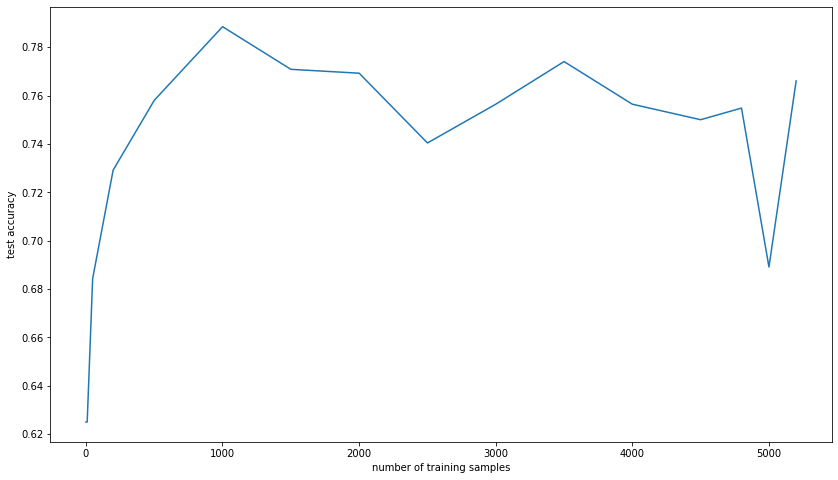

In [78]:
x = [1, 10, 50, 200, 501, 1001, 1501, 2001, 2501, 3001, 3501, 4001, 4501, 4800, 5001, 5200]
y = [0.625, 0.625, 0.6842948717948718, 0.7291666666666666, 0.7580128205128205, 0.7884615384615384, 0.7708333333333334, 0.7692307692307693, 0.7403846153846154, 0.7564102564102564, 0.7740384615384616, 0.7564102564102564, 0.75, 0.7548076923076923, 0.6891025641025641, 0.7660256410256411]
plt.xlabel("number of training samples")
plt.ylabel("test accuracy")
plt.plot(x,y)

In [55]:
#Performing hyperparameter tuning to improve performance
#Reference: https://scikit-learn.org/stable/modules/cross_validation.html; 
parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1]}
# 'solver':('adam', 'sgd'), 'learning_rate_init':[0.0002, 0.001, 0.005]
# 'hidden_layer_sizes':((100,), (100,50)), 'alpha':[0.001, 0.0001]}
scoring = ['f1', 'roc_auc', 'accuracy']
cv = 2

from sklearn.model_selection import GridSearchCV
clf_cv = GridSearchCV(MLPClassifier(), param_grid=parameters,cv=cv,scoring=scoring,verbose=RANDOM_SEED,refit='f1', n_jobs=4)
clf_cv.fit(X_train_hog, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done   2 out of   8 | elapsed:  2.4min remaining:  7.3min
[Parallel(n_jobs=4)]: Done   3 out of   8 | elapsed:  2.5min remaining:  4.1min
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=4)]: Done   5 out of   8 | elapsed:  4.3min remaining:  2.6min
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:  4.7min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  5.1min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'a

In [36]:
results = pd.DataFrame(clf_cv.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate_init,param_solver,params,split0_test_f1,split1_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,227.801515,0.033990,0.687931,0.035614,0.0002,adam,"{'learning_rate_init': 0.0002, 'solver': 'adam'}",0.977436,0.982719,0.980077,0.002641,3,0.994464,0.995525,0.994995,0.000531,2,0.966374,0.974388,0.970381,0.004007,3
1,200.569466,0.049110,0.655189,0.001557,0.0002,sgd,"{'learning_rate_init': 0.0002, 'solver': 'sgd'}",0.946006,0.957704,0.951855,0.005849,6,0.977157,0.981108,0.979132,0.001976,6,0.917081,0.935780,0.926430,0.009350,6
2,146.545795,18.303757,0.676707,0.018981,0.001,adam,"{'learning_rate_init': 0.001, 'solver': 'adam'}",0.978439,0.982212,0.980326,0.001886,2,0.994356,0.995430,0.994893,0.000537,4,0.967902,0.973624,0.970763,0.002861,2
3,199.766506,0.600627,0.646406,0.009124,0.001,sgd,"{'learning_rate_init': 0.001, 'solver': 'sgd'}",0.972585,0.979707,0.976146,0.003561,5,0.991974,0.993902,0.992938,0.000964,5,0.959113,0.969801,0.964457,0.005344,5
4,98.343230,12.506216,0.614259,0.152185,0.005,adam,"{'learning_rate_init': 0.005, 'solver': 'adam'}",0.978702,0.982184,0.980443,0.001741,1,0.994491,0.995419,0.994955,0.000464,3,0.968284,0.973624,0.970954,0.002670,1
5,111.918697,4.474455,0.254776,0.090059,0.005,sgd,"{'learning_rate_init': 0.005, 'solver': 'sgd'}",0.975585,0.983792,0.979688,0.004104,4,0.994517,0.995530,0.995024,0.000506,1,0.963699,0.975917,0.969808,0.006109,4


In [37]:
print(clf_cv.best_params_, clf_cv.best_score_)
print(clf_cv.best_estimator_)

{'learning_rate_init': 0.005, 'solver': 'adam'} 0.9804429592606043
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.005, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [38]:
#Choosing the model with best F1-score and accuracy
clf_final = MLPClassifier()
clf_final.fit(X_train_hog, y_train)
y_test_pred = clf_final.predict(X_test_hog)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.35      0.51       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



In [22]:
results = pd.DataFrame(clf_cv.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,49.468074,2.894912,0.12444,0.00502,{},0.979294,0.975591,0.982073,0.978986,0.002655,1,0.995324,0.993669,0.995707,0.9949,0.000884,1,0.969054,0.963876,0.973624,0.968851,0.003982,1


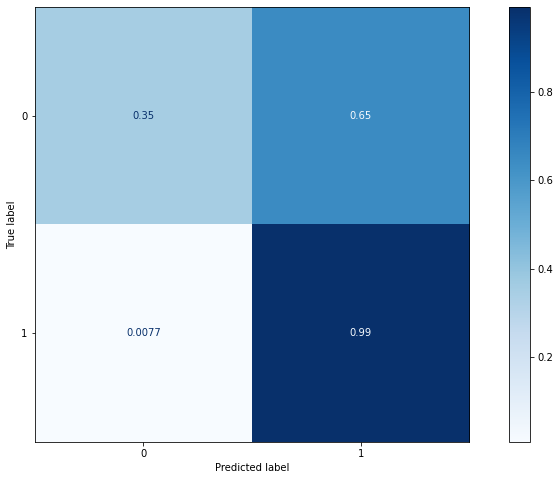

In [59]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_final, X_test_hog, y_test,cmap=plt.cm.Blues,normalize='true')  

In [25]:
for val in results.T:
    print(results.T[val]['params'],results.T[val]['mean_test_roc_auc'])

{} 0.9948999684186584


In [27]:
X_test_hog.shape

(624, 3780)

In [29]:
classification_report(y_test, y_test_pred)

'              precision    recall  f1-score   support\n\n           0       0.97      0.41      0.57       234\n           1       0.74      0.99      0.84       390\n\n    accuracy                           0.77       624\n   macro avg       0.85      0.70      0.71       624\nweighted avg       0.82      0.77      0.74       624\n'

No handles with labels found to put in legend.


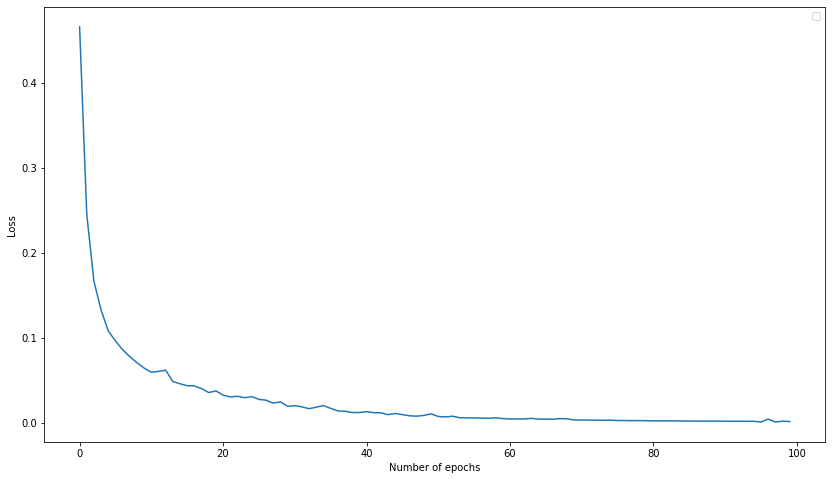

In [79]:
plt.plot(clf_final.loss_curve_[:100])
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

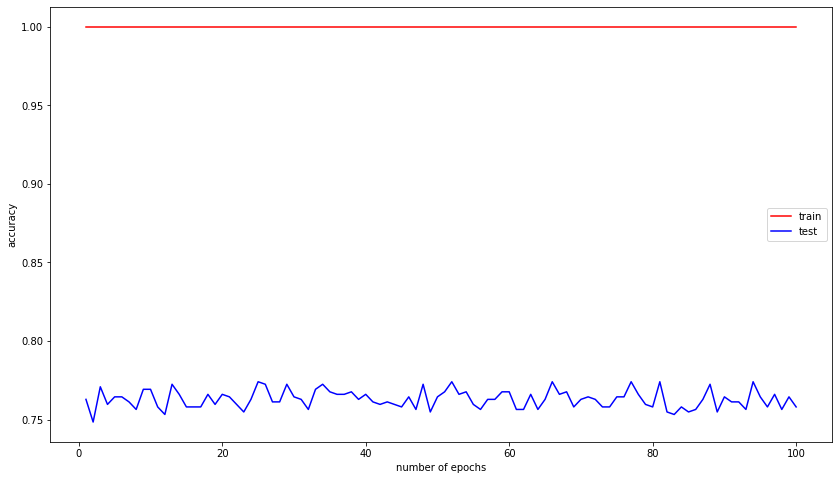

In [66]:
mlp = clf_final

X_train = X_train_hog
X_test = X_test_hog
y_train = y_train
y_test = y_test

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 100
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []
loss_train = []
loss_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(mlp.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(mlp.score(X_test, y_test))

    epoch += 1

""" Plot """
  
# Plotting both the curves simultaneously
plt.plot([i+1 for i in range(N_EPOCHS)], scores_train, color='r', label='train')
plt.plot([i+1 for i in range(N_EPOCHS)], scores_test, color='b', label='test')
  
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()

plt.show()